1. Use training=True while training and make it False while prediction. This is due to the fact that few layers like Dropout, BatchNormalization etc. are not used during prediction.
2. Keep fake images as 1 while training generator. While training discriminator make Fake=0 and Real=1, this helps in better learning.
3. Initially channels are less and keep on increasing with each layer in Generator as well as Discriminator.
4. Keep use_bias=False in each layer of Generator.
5. Avoid Dropout and BatchNorm in Generator.
6. Keep batch_size large approx 128.
7. Keep EPOCHS around 100+.
8. Kernel size of generator should be large: 4, 5.

In [1]:
import numpy as np
import sys
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10, mnist

In [2]:
tf.__version__

'2.1.0'

In [3]:
def shuffle(X,Y=None):
    idx = np.random.permutation(np.arange(len(X)))
    X = X[idx]
    if Y is not None:
        Y = Y[idx]
        return X,Y
    else:
        return X

In [4]:
home = "../input/stanford-dogs-dataset/images/Images"
folders = os.listdir(home)
img_paths_dog = ["{}/{}/{}".format(home,folder,img_name) for folder in folders for img_name in os.listdir(home+"/"+folder)]
print("Total dog paths:{}".format(len(img_paths_dog)))

Total dog paths:20580


In [5]:
home = "../input/the-car-connection-picture-dataset"
img_names = os.listdir(home)
img_paths_car = [home+"/"+name for name in img_names]
print("Total car paths:{}".format(len(img_paths_car)))

Total car paths:64467


In [6]:
img_paths = img_paths_car + img_paths_dog
img_paths = shuffle(np.array(img_paths))
print("Total paths:{}".format(len(img_paths)))

Total paths:85047


In [7]:
# from PIL import Image
# img = Image.open(img_paths[0])
# plt.imshow(img)
# plt.show()

# img = img.resize((256,256), resample=Image.NEAREST)
# plt.imshow(img)
# plt.show()

# np.array(img).shape

### 1. Load data

Load data an numpy images.

In [8]:
def read_image(img_path, img_shape, normalization="tanh"):
    img = Image.open(img_path)
    img = img.resize((img_shape[0], img_shape[1]))
    img = np.array(img)
    if normalization is not None and normalization=="tanh":
        img = (img-127.5) / 127.5
    return img

def data_gen(x, batch_size):
    x = shuffle(x)
    while True:
        start=0
        for end in range(0,len(x), batch_size)[1:]:
            x_batch = x[start:end]
            start=end
            yield x_batch
            
def data_gen_pil(img_paths, batch_size, img_shape, img_normalization):
    img_paths = shuffle(np.array(img_paths))
    while True:
        start=0
        for end in range(0,len(img_paths), batch_size)[1:]:
            imgs = [read_image(path, img_shape, img_normalization) for path in img_paths[start:end]]
            start = end
            imgs = np.array(imgs) 
            yield imgs
            

def get_model_param_count(model):
    lst = model.trainable_variables
    prod = 0
    for temp in lst:
        prod += np.product(temp.shape[1:])
    return prod

# g = make_generator_model()
# p=1
# for l in g.trainable_variables:
#     print(l.shape)
#     p += np.product(l.shape[1:])
# get_model_param_count(g)

In [9]:

def loss_fn(y_true, y_pred):
    loss = loss_obj(y_true, y_pred)
    #mean_loss = tf.reduce_mean(loss)
    return loss

# def loss_fn_gen(y_fake):
#     fake_loss = loss_obj(np.ones(shape=[y_fake.shape[0]]), tf.squeeze(y_fake))
#     #fake_loss = tf.reduce_mean(np.ones(shape=[y_fake.shape[0]]) * tf.squeeze(y_fake))
#     return fake_loss

def loss_fn_gen(y_fake):
    # Generator could create model collapse leading to generating similar type of images.
    # To overcome this introduce some noise in generator by making labels in range 0.9 to 1 instead of directly 1.
    fake_loss = loss_obj(np.ones(shape=[y_fake.shape[0]]) * np.random.uniform(0.9,1.0, [y_fake.shape[0]]), tf.squeeze(y_fake))
    #fake_loss = tf.reduce_mean(np.ones(shape=[y_fake.shape[0]]) * tf.squeeze(y_fake))
    return fake_loss

def loss_fn_dis(y_fake, y_actual):
    fake_loss = loss_obj(np.zeros(shape=[y_fake.shape[0]]), tf.squeeze(y_fake))
    actual_loss = loss_obj(np.ones(shape=[y_actual.shape[0]]), tf.squeeze(y_actual))
    #fake_loss = tf.reduce_mean(np.zeros(shape=[y_fake.shape[0]]) * tf.squeeze(y_fake))
    #actual_loss = tf.reduce_mean(np.ones(shape=[y_actual.shape[0]]) * tf.squeeze(y_actual))
    loss = fake_loss + actual_loss
    return loss

#loss_fn(np.random.randn(3,1), np.random.randn(3,1))

### Using Sequential model

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Reshape((4,4,256)))
    #assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 8, 8, 512)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 8, 8, 512)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 8, 8, 512)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 8, 8, 512)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
#     model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', use_bias=False))
#     #assert model.output_shape == (None, 8, 8, 512)
#     #model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(0.2))
    
#     model.add(layers.Conv2DTranspose(256, (4,4), strides=(1,1), padding='same', use_bias=False))
#     #assert model.output_shape == (None, 8, 8, 512)
#     #model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(3, (3,3), strides=(1,1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64,64, 3)

    return model

arr = np.random.randn(1,100)
gen_temp = make_generator_model()
gen_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262144    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

In [11]:
def make_discriminator_model(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(1,1), padding='same',
                                     input_shape=img_shape))
    model.add(layers.LeakyReLU(0.2))
    #model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    #model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    #model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    #model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    #model.add(layers.Dropout(0.3))
    
#     model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU(0.2))
#     #model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    #opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    #model.compile(loss='binary_crossentropy', optimizer=optimizer_dis, metrics=['accuracy'])

    return model

In [12]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".


@tf.function
def train_step(gen, dis, noise_shape, batch_size, data_generator):
    noise = tf.random.normal([batch_size*2, noise_shape])  #tf.random.uniform(shape=[batch_size*2, noise_shape], minval=-3.0, maxval=3.0)
    images = next(data_generator)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise, training=True)
        fake_output = dis(generated_images, training=True)
        gen_loss = loss_fn_gen(fake_output)
        
        real_output = dis(images, training=True)        
        disc_loss = loss_fn_dis(fake_output[:(batch_size//2)], real_output)
        

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis.trainable_variables)

    optimizer_gen.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    optimizer_dis.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))
    return gen_loss, disc_loss, generated_images


# @tf.function
# def train_step(gen, dis, noise_shape, batch_size, data_generator):
#     with tf.GradientTape() as disc_tape:
#         noise = tf.random.normal([batch_size, noise_shape])
#         fake_imgs = gen(noise, training=True)
#         fake_out = dis(fake_imgs, training=True)
        
#         real_imgs = next(data_generator)
#         real_out = dis(real_imgs, training=True)
        
#         disc_loss = loss_fn_dis(real_out, )

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         noise = tf.random.normal([batch_size*2, noise_shape])
#         images = next(data_generator)
        
#         generated_images = gen(noise, training=True)
#         fake_output = dis(generated_images, training=True)
#         gen_loss = loss_fn_gen(fake_output)
        
#         real_output = dis(images, training=True)        
#         disc_loss = loss_fn_dis(real_output, fake_output[:(batch_size//2)])
        

#     gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, dis.trainable_variables)

#     optimizer_gen.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
#     optimizer_dis.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))
#     return gen_loss, disc_loss, generated_images
    
    
def train(batch_size, epochs, iterations, noise_shape, img_shape, data_generator, gen, dis):
    print("***************************")
    print("Generator params:{}".format(get_model_param_count(gen)))
    print("Discriminator params:{}".format(get_model_param_count(dis)))
    print("Generator / Discriminator params: {}".format(get_model_param_count(gen) / get_model_param_count(dis)))
    print("***************************")
    
    losses_gen = []
    losses_dis = []
    for epoch in range(epochs):
        for it in range(iterations):
            loss_gen, loss_dis, gen_out = train_step(gen, dis, noise_shape, batch_size, data_generator)
            sys.stdout.write("\r{}/{} Epoch {}/{} \tLoss Gen:{} Loss Dis:{}".format(it+1, iterations, epoch+1, epochs, loss_gen, loss_dis))
            sys.stdout.flush()
        losses_gen.append(loss_gen)
        losses_dis.append(loss_dis)
        sys.stdout.write("\r{}/{} Epoch {}/{} \tLoss Gen:{} Loss Dis:{}\n".format(it+1, iterations, epoch+1, epochs, loss_gen, loss_dis))
        sys.stdout.flush()
        fig = plt.figure(figsize=(20,10))
        n_imgs = 8
        for i in range(n_imgs):
            plt.subplot(1,n_imgs,i+1)
            img_cur = (gen_out[i,:,:,:] + 1) / 2.0
            plt.imshow(img_cur)
            plt.axis("off")
        plt.show()
    return losses_gen, losses_dis, gen, dis

### Execution

In [13]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = (x_train - 127.5) / 127.5
# x_train.shape

In [14]:
#x_train = [read_image(path, (128,128,3), normalization="tanh") for path in tqdm(img_paths)]


***************************
Generator params:399616
Discriminator params:172615.0
Generator / Discriminator params: 2.3150711120122818
***************************
664/664 Epoch 1/100 	Loss Gen:2.7306110858917236 Loss Dis:0.4388558864593506


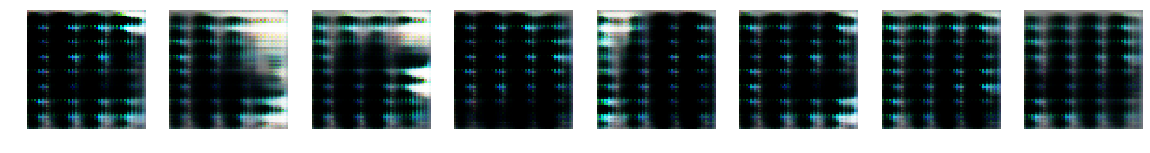

664/664 Epoch 2/100 	Loss Gen:1.3499726057052612 Loss Dis:1.0469965934753418


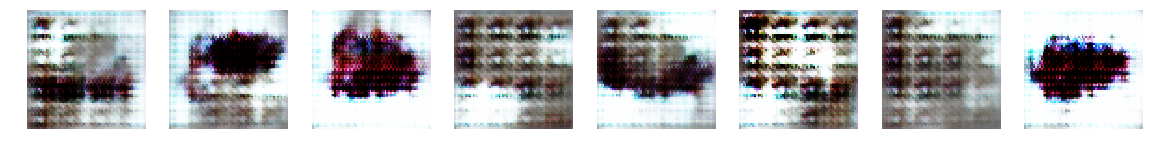

664/664 Epoch 3/100 	Loss Gen:1.6856406927108765 Loss Dis:0.699324369430542


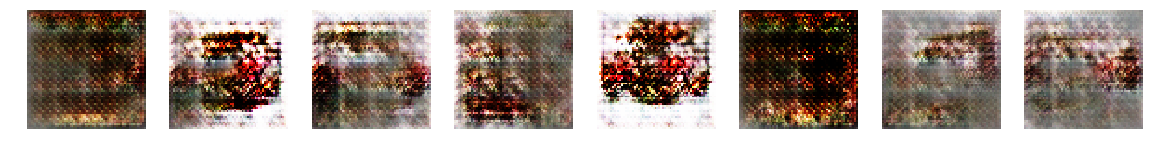

664/664 Epoch 4/100 	Loss Gen:2.0174689292907715 Loss Dis:0.4401116967201233


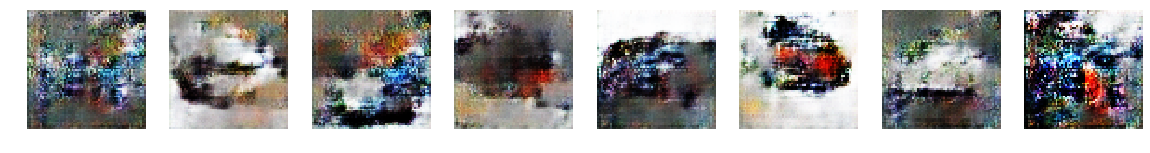

664/664 Epoch 5/100 	Loss Gen:3.2539443969726562 Loss Dis:0.2740769684314728


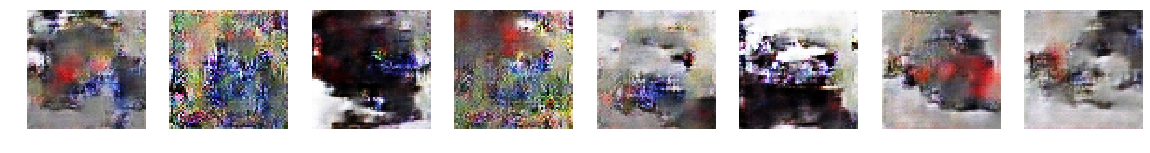

664/664 Epoch 6/100 	Loss Gen:5.094305038452148 Loss Dis:0.18456074595451355


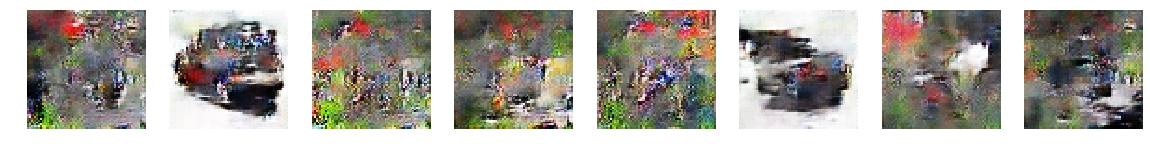

664/664 Epoch 7/100 	Loss Gen:5.338094234466553 Loss Dis:0.06439073383808136


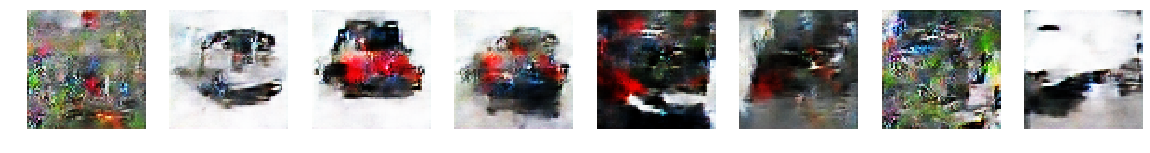

664/664 Epoch 8/100 	Loss Gen:6.111793518066406 Loss Dis:0.09663409739732742


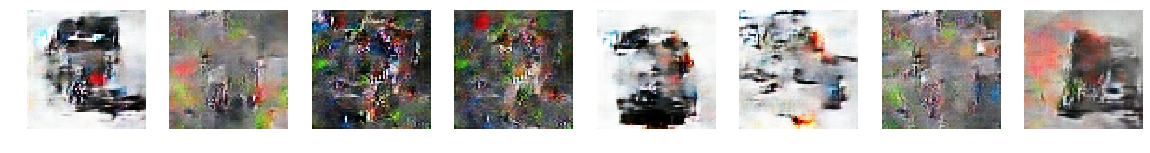

664/664 Epoch 9/100 	Loss Gen:7.9241743087768555 Loss Dis:0.05703918635845184


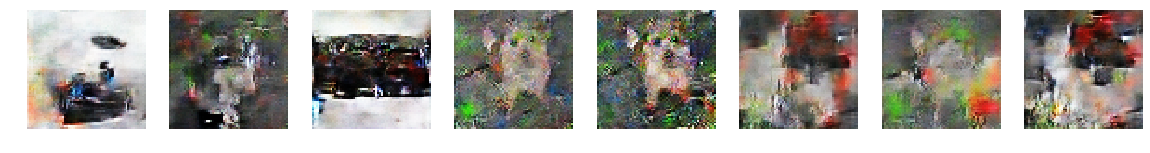

664/664 Epoch 10/100 	Loss Gen:6.755497932434082 Loss Dis:0.07750087231397629


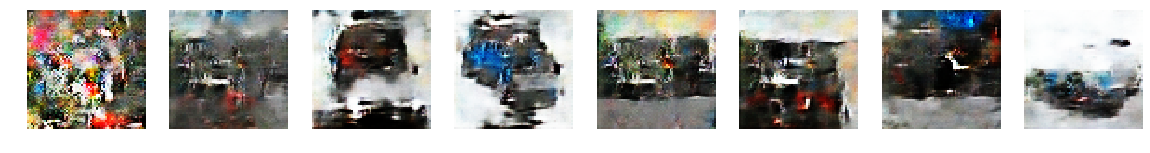

664/664 Epoch 11/100 	Loss Gen:7.763171195983887 Loss Dis:0.02213958464562893


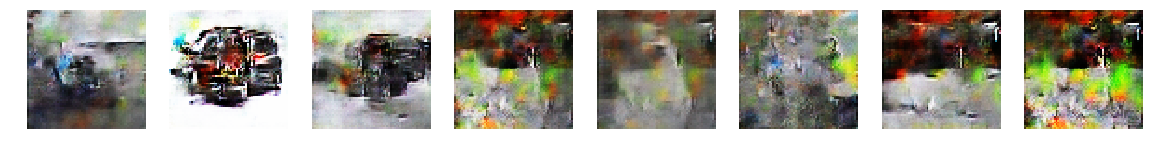

664/664 Epoch 12/100 	Loss Gen:5.805371284484863 Loss Dis:0.049456436187028885


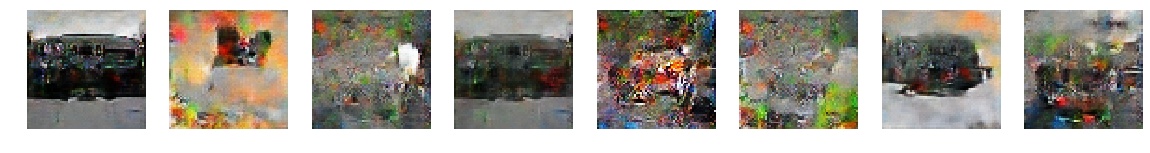

664/664 Epoch 13/100 	Loss Gen:7.376374244689941 Loss Dis:0.07851407676935196


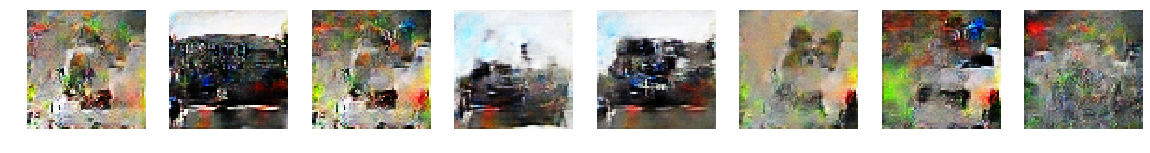

664/664 Epoch 14/100 	Loss Gen:6.2871198654174805 Loss Dis:0.09161756932735443


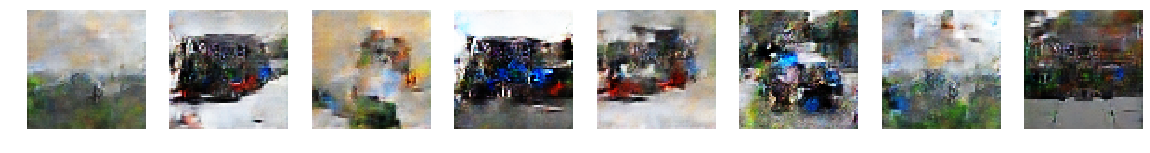

664/664 Epoch 15/100 	Loss Gen:6.909416198730469 Loss Dis:0.047414738684892654


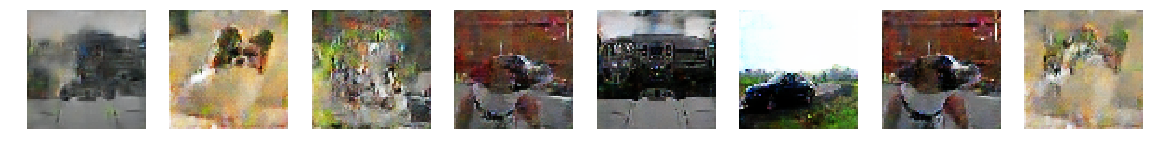

664/664 Epoch 16/100 	Loss Gen:5.123197078704834 Loss Dis:0.10468404740095139


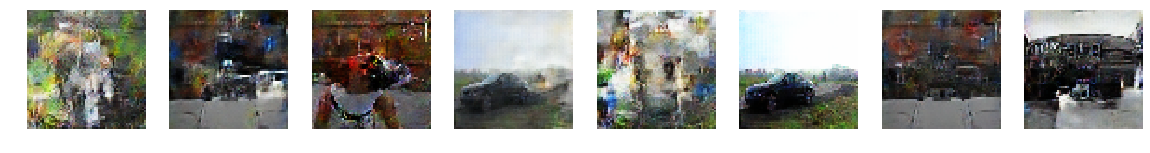

664/664 Epoch 17/100 	Loss Gen:6.002081394195557 Loss Dis:0.10019826143980026


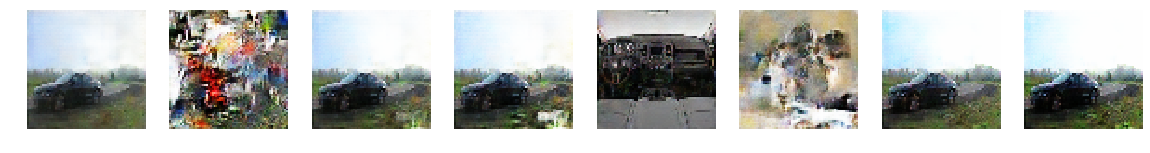

664/664 Epoch 18/100 	Loss Gen:5.534214496612549 Loss Dis:0.24382472038269043


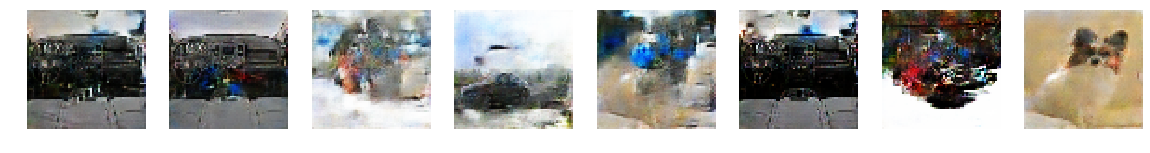

664/664 Epoch 19/100 	Loss Gen:4.981170177459717 Loss Dis:0.11333067715167999


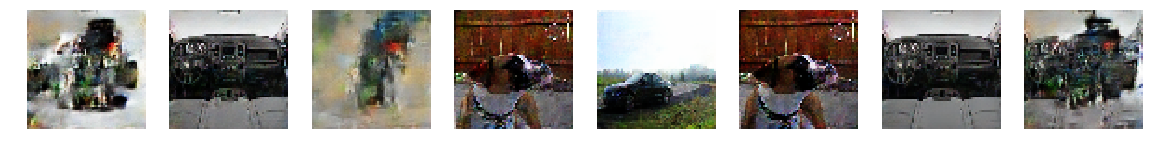

664/664 Epoch 20/100 	Loss Gen:5.4269938468933105 Loss Dis:0.08631779253482819


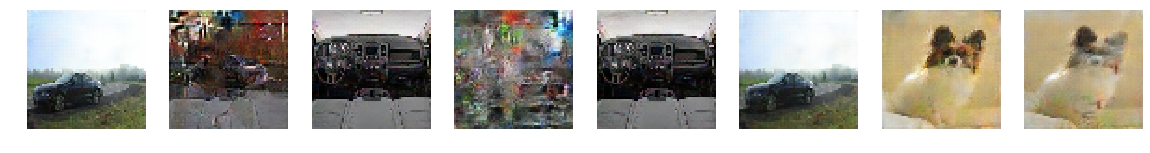

664/664 Epoch 24/100 	Loss Gen:5.4202117919921875 Loss Dis:0.0835275948047638


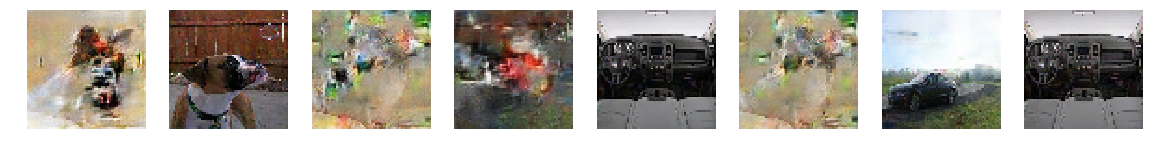

664/664 Epoch 25/100 	Loss Gen:7.954829692840576 Loss Dis:0.12414078414440155


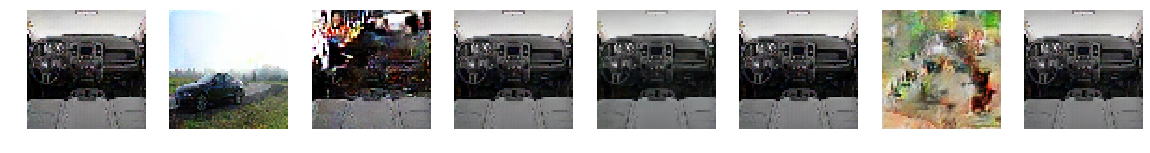

664/664 Epoch 26/100 	Loss Gen:5.537005424499512 Loss Dis:0.06872313469648361


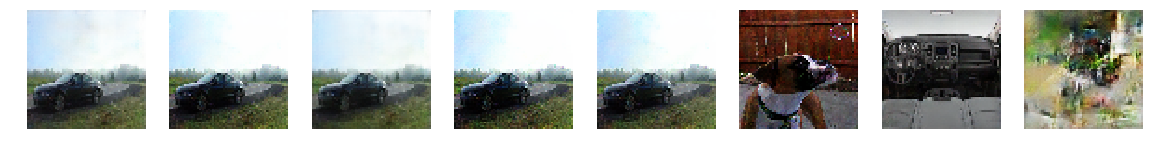

664/664 Epoch 28/100 	Loss Gen:9.237980842590332 Loss Dis:0.05552978813648224


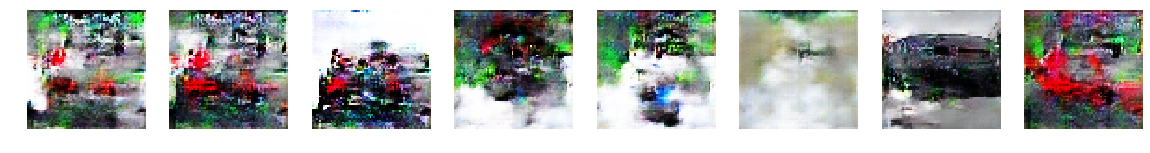

664/664 Epoch 29/100 	Loss Gen:10.346004486083984 Loss Dis:0.016220804303884506


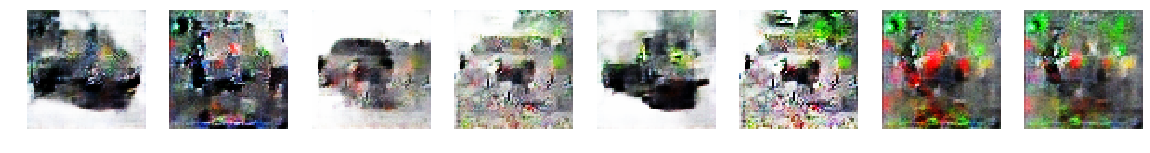

664/664 Epoch 32/100 	Loss Gen:5.677825927734375 Loss Dis:0.10230754315853119


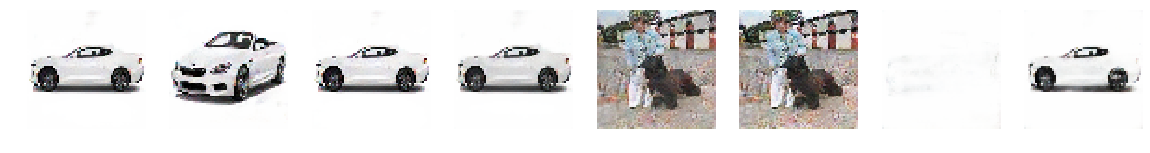

664/664 Epoch 33/100 	Loss Gen:6.116288185119629 Loss Dis:0.06967472285032272


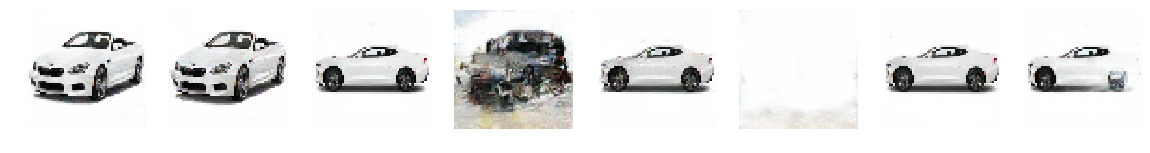

664/664 Epoch 34/100 	Loss Gen:5.390152454376221 Loss Dis:0.09970199316740036


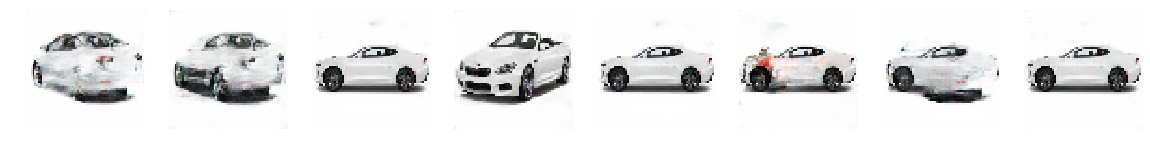

664/664 Epoch 37/100 	Loss Gen:10.407125473022461 Loss Dis:0.5145986080169678


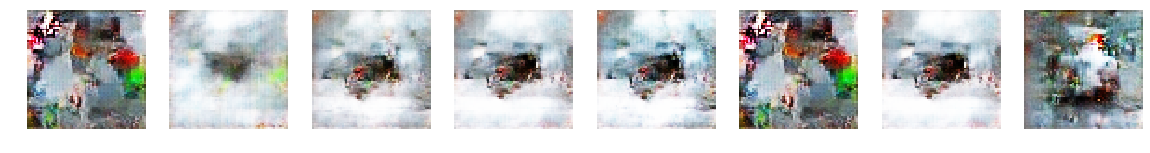

664/664 Epoch 38/100 	Loss Gen:13.253026008605957 Loss Dis:0.010477494448423386


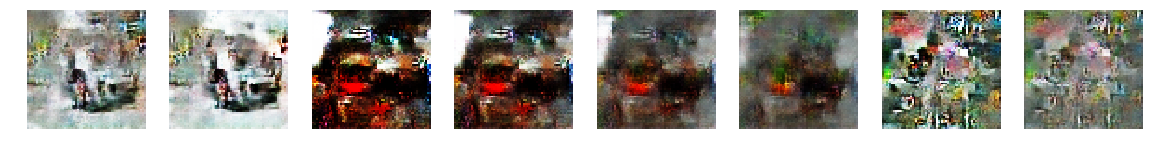

664/664 Epoch 39/100 	Loss Gen:13.574031829833984 Loss Dis:0.1217833012342453


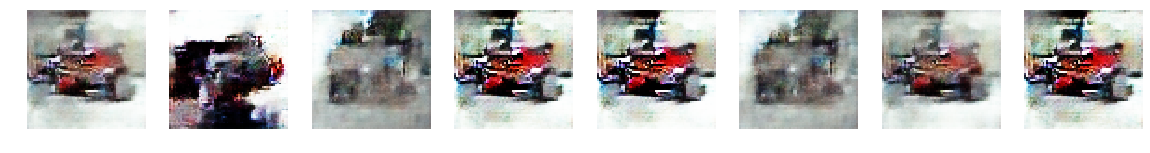

664/664 Epoch 41/100 	Loss Gen:14.670488357543945 Loss Dis:8.597315900260583e-05


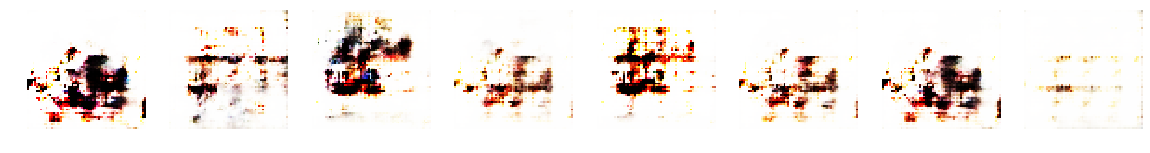

664/664 Epoch 43/100 	Loss Gen:5.051563262939453 Loss Dis:0.10239895433187485


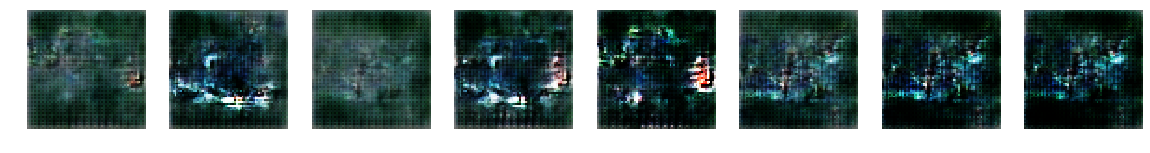

664/664 Epoch 45/100 	Loss Gen:12.861166000366211 Loss Dis:0.0007888145046308637


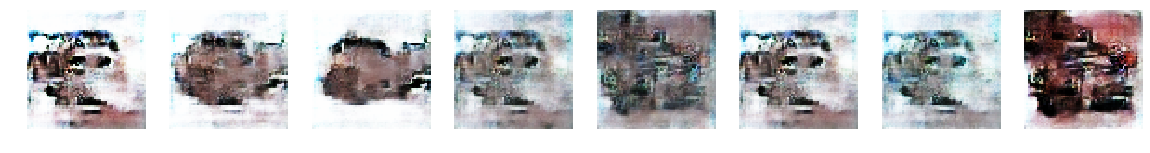

664/664 Epoch 47/100 	Loss Gen:8.143400192260742 Loss Dis:0.023617003113031387


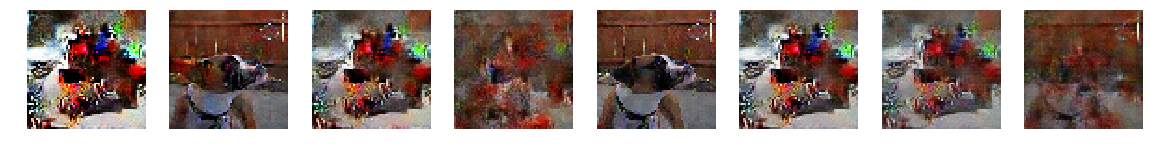

664/664 Epoch 49/100 	Loss Gen:5.812286376953125 Loss Dis:0.07124848663806915


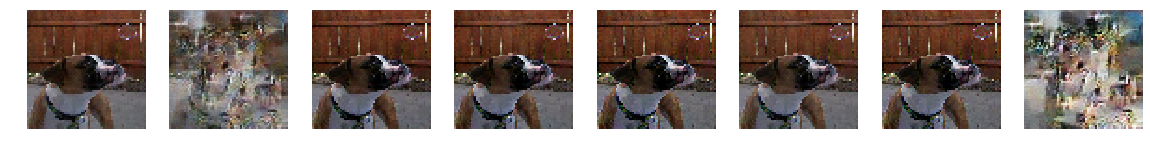

664/664 Epoch 56/100 	Loss Gen:6.741837501525879 Loss Dis:0.06359320878982544


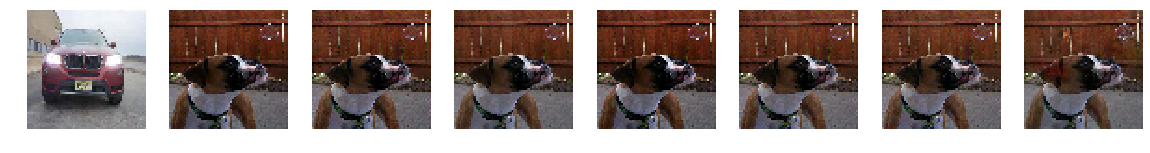

664/664 Epoch 60/100 	Loss Gen:8.90085506439209 Loss Dis:0.07852956652641296


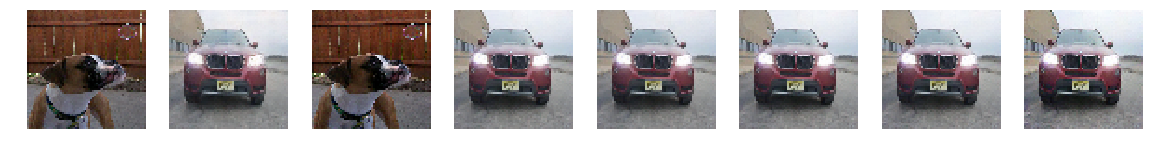

664/664 Epoch 62/100 	Loss Gen:7.491889953613281 Loss Dis:0.0678602010011673


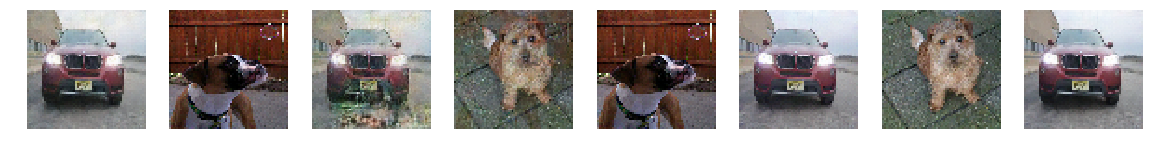

664/664 Epoch 64/100 	Loss Gen:9.528481483459473 Loss Dis:0.030261799693107605


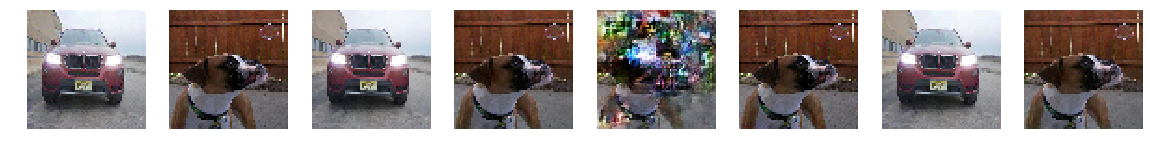

664/664 Epoch 71/100 	Loss Gen:10.242891311645508 Loss Dis:0.05192413926124573


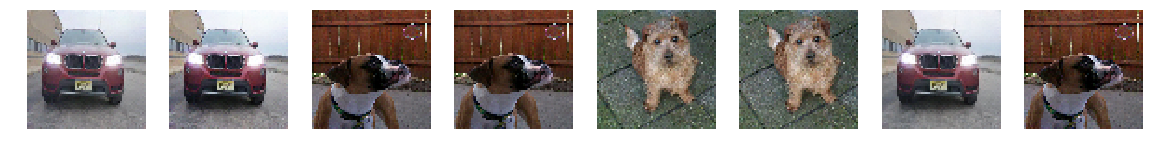

664/664 Epoch 73/100 	Loss Gen:11.559741973876953 Loss Dis:0.01981637254357338


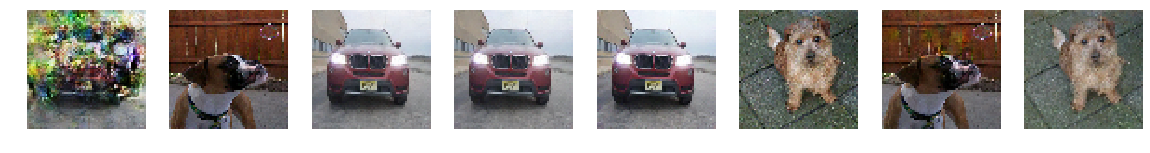

664/664 Epoch 75/100 	Loss Gen:14.670488357543945 Loss Dis:0.4820297062397003


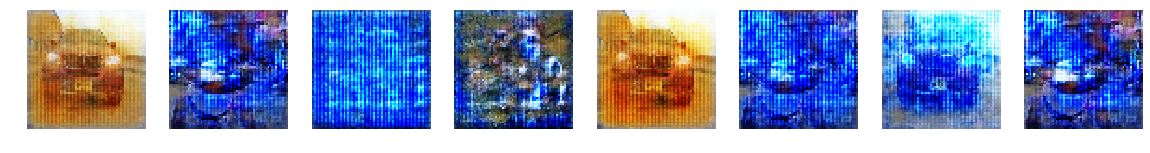

664/664 Epoch 77/100 	Loss Gen:14.670488357543945 Loss Dis:0.48202964663505554


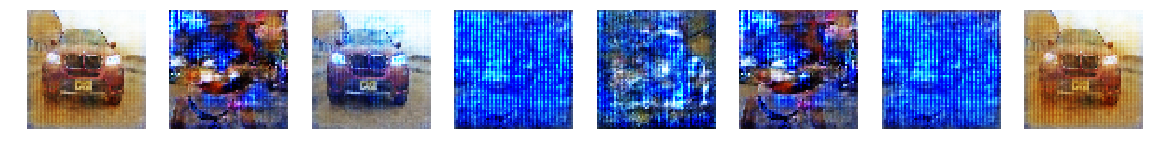

664/664 Epoch 79/100 	Loss Gen:14.670488357543945 Loss Dis:0.48202964663505554


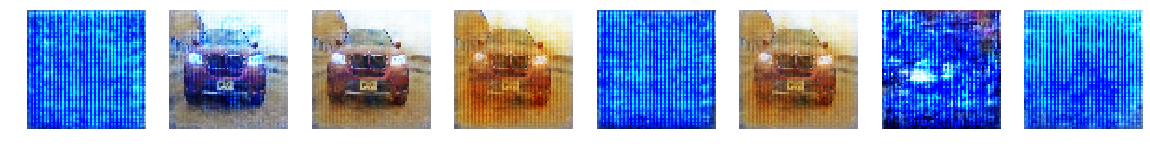

664/664 Epoch 86/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


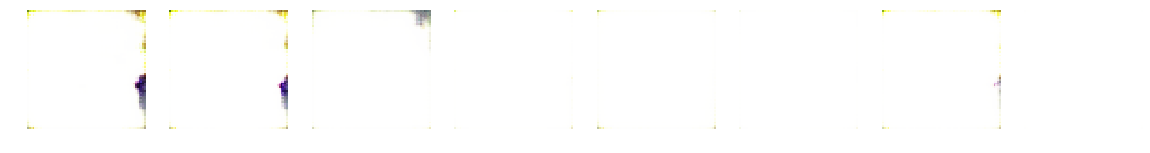

664/664 Epoch 87/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


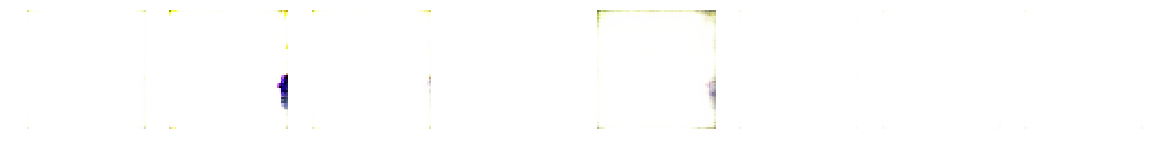

664/664 Epoch 90/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


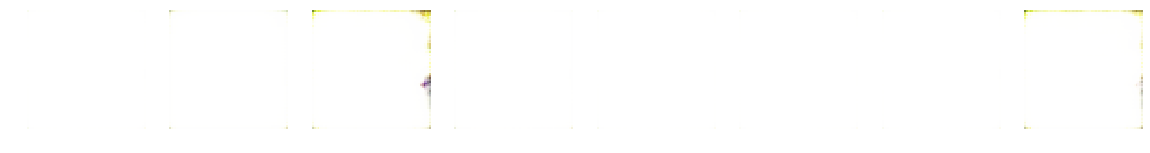

664/664 Epoch 92/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


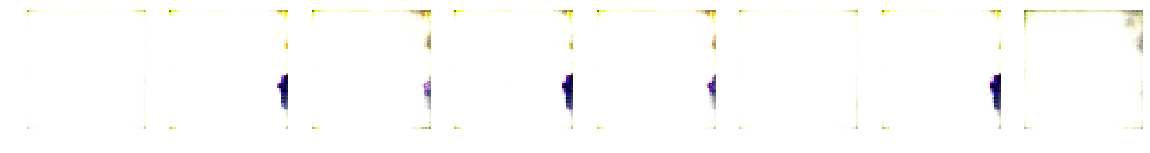

664/664 Epoch 94/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


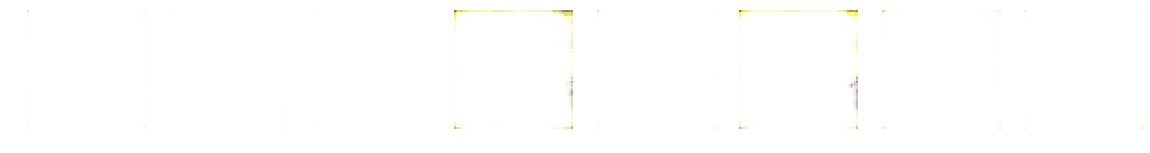

664/664 Epoch 96/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


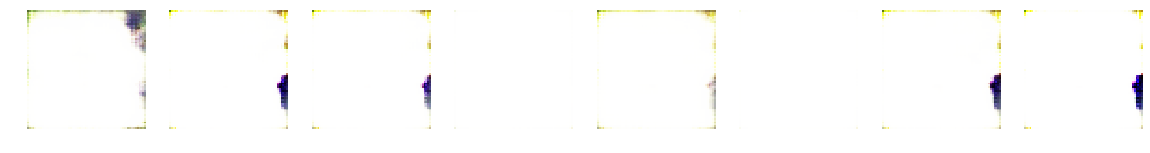

664/664 Epoch 97/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


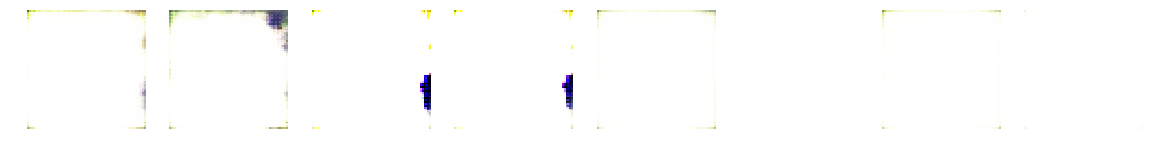

664/664 Epoch 98/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0


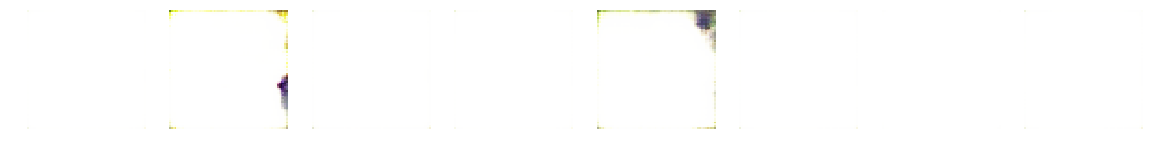

629/664 Epoch 99/100 	Loss Gen:14.670488357543945 Loss Dis:-0.0

In [15]:
optimizer_gen = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
optimizer_dis = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=False)



BATCH_SIZE = 128
EPOCHS=100
ITERATIONS = len(img_paths)//BATCH_SIZE
NOISE_SHAPE = 100
IMG_SHAPE = (64,64, 3)
#DATA_GENERATOR = data_gen(x_train, BATCH_SIZE)
DATA_GENERATOR = data_gen_pil(img_paths, BATCH_SIZE, IMG_SHAPE, img_normalization="tanh")

gen = make_generator_model()
dis = make_discriminator_model(IMG_SHAPE)
losses_gen, losses_dis, gen, dis = train(BATCH_SIZE, EPOCHS, ITERATIONS, NOISE_SHAPE, IMG_SHAPE, DATA_GENERATOR, gen, dis)

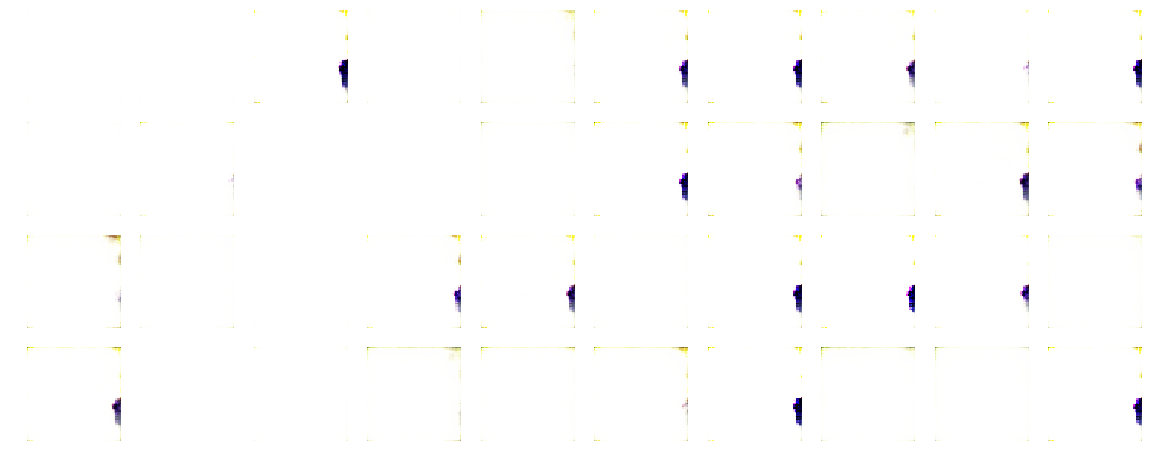

In [16]:
# Generate random images.

num_samples = 40
noise = np.random.uniform(-2,2,(num_samples,100)) #np.random.randn(num_samples,100)
generated_imgs = gen(noise, training=False)
generated_imgs = (generated_imgs + 1.0) / 2.0

ncols=10
nrows= (num_samples // ncols) + 1

fig = plt.figure(figsize=(20, 2*nrows))
for i, img in enumerate(generated_imgs):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()